# Project - Mobile recommender system

In [1]:
import networkx as nx 
import pandas as pd
import numpy as numpy
import random
from tqdm import tqdm
from sklearn.decomposition import PCA
from ge import DeepWalk
import matplotlib.pyplot as plt
import warnings
import pickle
import os

warnings.filterwarnings('ignore')
data_path = os.environ.get('DATA_PATH') + 'AI_Cheats/'

ModuleNotFoundError: No module named 'deepctr'

In [2]:
# 数据加载
df = pd.read_csv(data_path + 'fresh_comp_offline/tianchi_fresh_comp_train_user.csv')
df.head()


,user_id,item_id,behavior_type,user_geohash,item_category,time
0,10001082,285259775,1,97lk14c,4076,2014-12-08 18
1,10001082,4368907,1,NaN,5503,2014-12-12 12
2,10001082,4368907,1,NaN,5503,2014-12-12 12
3,10001082,53616768,1,NaN,9762,2014-12-02 15
4,10001082,151466952,1,NaN,5232,2014-12-12 11


In [4]:
# 2014 年 12 月 19 日
# 设置解析
dateparse = lambda dates: pd.to_datetime(dates, format='%Y-%m-%d %H')
file_name = data_path + 'fresh_comp_offline/tianchi_fresh_comp_train_user.csv'
batch = 0
for df in pd.read_csv(open(file_name, 'r'), parse_dates=['time'],
      index_col=['time'],
      date_parser = dateparse,
      chunksize = 1000000):
  # 关注 behavior_type = 3 或 4
  df_act_34 = df[df['behavior_type'].isin([3, 4])]
  # 如果想要追加文件的话，设置 mode=a
  df_act_34.to_csv(data_path + 'fresh_comp_offline/act_34.csv', columns=['user_id', 'item_id', 'behavior_type', 'item_category'], header=False, mode='a')
  batch = batch + 1
  print('chunk {} done'.format(batch))

chunk 1 done
chunk 2 done
chunk 3 done
chunk 4 done
chunk 5 done
chunk 6 done
chunk 7 done
chunk 8 done
chunk 9 done
chunk 10 done
chunk 11 done
chunk 12 done
chunk 13 done
chunk 14 done
chunk 15 done
chunk 16 done
chunk 17 done
chunk 18 done
chunk 19 done
chunk 20 done
chunk 21 done
chunk 22 done
chunk 23 done
chunk 24 done


In [5]:
df_act_34 = df[df['behavior_type'].isin([3,4])]
df_act_34.reset_index(inplace = True)
df_act_34.to_pickle(data_path + 'fresh_comp_offline/df_act_34.pkl')

In [6]:
%%time
with open(data_path  + 'fresh_comp_offline/df_act_34.pkl', 'rb') as file:
  df_act_34 = pickle.load(file)
df_act_34.head()

CPU times: user 2 ms, sys: 2.85 ms, total: 4.85 ms
Wall time: 6.45 ms


,time,user_id,item_id,behavior_type,user_geohash,item_category
0,2014-12-10 09:00:00,62263109,236849384,3,NaN,13374
1,2014-12-08 21:00:00,62263109,192329209,3,NaN,2252
2,2014-11-30 09:00:00,62263109,370979534,4,NaN,7182
3,2014-12-02 20:00:00,62264600,140536486,4,NaN,3156
4,2014-12-18 10:00:00,62264600,385172785,4,NaN,5894


In [7]:
df_act_34.sort_values(by=['time'], ascending=True, inplace=True)
df_act_34

,time,user_id,item_id,behavior_type,user_geohash,item_category
9098,2014-11-18 00:00:00,64869447,65179792,3,NaN,6977
8553,2014-11-18 00:00:00,64869447,306602956,3,NaN,6977
9506,2014-11-18 00:00:00,64869447,141941141,3,NaN,9343
3160,2014-11-18 00:00:00,63297266,370629944,3,NaN,3783
8831,2014-11-18 00:00:00,64869447,233694612,3,NaN,6977
...,...,...,...,...,...,...
3257,2014-12-18 23:00:00,63344906,162159421,3,NaN,5894
9764,2014-12-18 23:00:00,65079450,277346109,3,mtj6ml5,5894
4024,2014-12-18 23:00:00,63623282,71364370,3,99vskiv,2936
3195,2014-12-18 23:00:00,63344906,1224081,3,NaN,5399


In [8]:
df_act_34.drop_duplicates(['user_id', 'item_id', 'behavior_type'], keep='last', inplace=True)
df_act_34.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8315 entries, 3161 to 3979
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   time           8315 non-null   datetime64[ns]
 1   user_id        8315 non-null   int64         
 2   item_id        8315 non-null   int64         
 3   behavior_type  8315 non-null   int64         
 4   user_geohash   2400 non-null   object        
 5   item_category  8315 non-null   int64         
dtypes: datetime64[ns](1), int64(4), object(1)
memory usage: 454.7+ KB


In [9]:
# 所有 behavior_type = 3 的数据
df_time_3 = df_act_34[df_act_34['behavior_type'] == 3][['user_id', 'item_id', 'time']]
df_time_3

,user_id,item_id,time
3161,63297266,370629944,2014-11-18 00:00:00
5547,6414743,11952,2014-11-18 00:00:00
5029,63914735,234362333,2014-11-18 03:00:00
1916,63011216,205405736,2014-11-18 05:00:00
1927,63011216,325436096,2014-11-18 05:00:00
...,...,...,...
3257,63344906,162159421,2014-12-18 23:00:00
9764,65079450,277346109,2014-12-18 23:00:00
4024,63623282,71364370,2014-12-18 23:00:00
3195,63344906,1224081,2014-12-18 23:00:00


In [10]:
# 所有 behavior_type = 4 的数据
df_time_4 = df_act_34[df_act_34['behavior_type'] == 4][['user_id', 'item_id', 'time']]
df_time_4

,user_id,item_id,time
3666,634740,160926997,2014-11-18 02:00:00
4319,63736178,270865070,2014-11-18 07:00:00
1556,62928743,192494988,2014-11-18 08:00:00
1826,6299456,156426707,2014-11-18 09:00:00
3522,63432779,40116012,2014-11-18 09:00:00
...,...,...,...
6084,64243962,395310441,2014-12-18 22:00:00
4854,63914735,69648712,2014-12-18 22:00:00
7721,64642563,269329111,2014-12-18 22:00:00
7719,64642563,108555577,2014-12-18 23:00:00


In [11]:
df_time_3.rename(columns={'time':'time3'}, inplace=True)
df_time_4.rename(columns={'time':'time4'}, inplace=True)

In [12]:
df_time_3

,user_id,item_id,time3
3161,63297266,370629944,2014-11-18 00:00:00
5547,6414743,11952,2014-11-18 00:00:00
5029,63914735,234362333,2014-11-18 03:00:00
1916,63011216,205405736,2014-11-18 05:00:00
1927,63011216,325436096,2014-11-18 05:00:00
...,...,...,...
3257,63344906,162159421,2014-12-18 23:00:00
9764,65079450,277346109,2014-12-18 23:00:00
4024,63623282,71364370,2014-12-18 23:00:00
3195,63344906,1224081,2014-12-18 23:00:00


In [13]:
df_time = pd.merge(df_time_3, df_time_4, on = ['user_id', 'item_id'], how='left')
df_time

,user_id,item_id,time3,time4
0,63297266,370629944,2014-11-18 00:00:00,NaT
1,6414743,11952,2014-11-18 00:00:00,2014-11-19 23:00:00
2,63914735,234362333,2014-11-18 03:00:00,NaT
3,63011216,205405736,2014-11-18 05:00:00,NaT
4,63011216,325436096,2014-11-18 05:00:00,NaT
...,...,...,...,...
5993,63344906,162159421,2014-12-18 23:00:00,NaT
5994,65079450,277346109,2014-12-18 23:00:00,NaT
5995,63623282,71364370,2014-12-18 23:00:00,NaT
5996,63344906,1224081,2014-12-18 23:00:00,NaT


In [14]:
df_time_34 = df_time.dropna()
df_time_34

,user_id,item_id,time3,time4
1,6414743,11952,2014-11-18 00:00:00,2014-11-19 23:00:00
15,63881240,146129378,2014-11-18 09:00:00,2014-11-18 09:00:00
22,65175897,222368622,2014-11-18 10:00:00,2014-11-18 10:00:00
24,62451266,170078509,2014-11-18 11:00:00,2014-11-18 11:00:00
25,64869447,306330885,2014-11-18 11:00:00,2014-11-18 14:00:00
...,...,...,...,...
5931,62532170,83050674,2014-12-18 20:00:00,2014-12-18 20:00:00
5935,62390834,144318384,2014-12-18 20:00:00,2014-12-18 20:00:00
5945,63623282,65359931,2014-12-18 21:00:00,2014-12-18 21:00:00
5965,63220007,305348881,2014-12-18 21:00:00,2014-12-18 21:00:00


In [15]:
# 计算从加购 => 购买的时间差
# 使用pd.to_datetime 转换时间格式
delta_time = pd.to_datetime(df_time_34['time4']) - pd.to_datetime(df_time_34['time3'])
delta_time

1      1 days 23:00:00
15     0 days 00:00:00
22     0 days 00:00:00
24     0 days 00:00:00
25     0 days 03:00:00
             ...      
5931   0 days 00:00:00
5935   0 days 00:00:00
5945   0 days 00:00:00
5965   0 days 00:00:00
5968   0 days 00:00:00
Length: 1436, dtype: timedelta64[ns]

In [16]:
delta_hour = []
for i in range(len(delta_time)):
  d_hour = delta_time.iloc[i].days * 24 + delta_time.iloc[i]._h
  if d_hour<0:
    continue
  else:
    delta_hour.append(d_hour)
delta_hour

[24,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 144,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 312,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 96,
 0,
 0,
 0,
 24,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 216,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 24,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 24,
 24,
 0,
 0,
 144,
 144,
 144,
 0,
 0,
 1

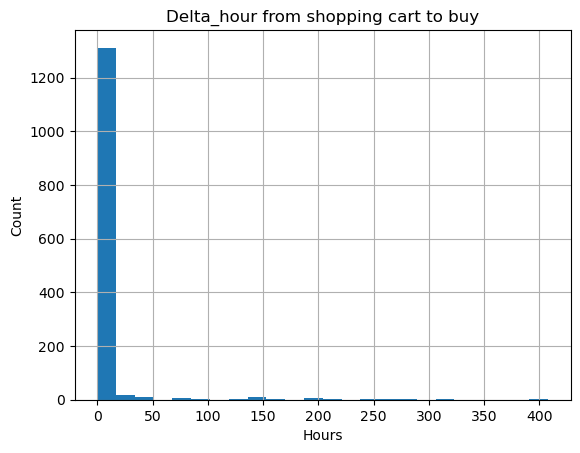

In [17]:
plt.hist(delta_hour, bins=24)
plt.xlabel('Hours')
plt.ylabel('Count')
plt.title('Delta_hour from shopping cart to buy')
plt.grid(True)
plt.show()

In [19]:
# 查看2014-12-18，当时放到购物车中的用户
ui_pred = df_time[df_time['time4'].isnull() & (df_time['time3'] >= '2014-12-18 00')]
ui_pred

,user_id,item_id,time3,time4
5777,64151780,265122669,2014-12-18 00:00:00,NaT
5778,64151780,137377762,2014-12-18 00:00:00,NaT
5782,64388982,158711546,2014-12-18 00:00:00,NaT
5783,64388982,136202901,2014-12-18 00:00:00,NaT
5785,634740,322616467,2014-12-18 01:00:00,NaT
...,...,...,...,...
5993,63344906,162159421,2014-12-18 23:00:00,NaT
5994,65079450,277346109,2014-12-18 23:00:00,NaT
5995,63623282,71364370,2014-12-18 23:00:00,NaT
5996,63344906,1224081,2014-12-18 23:00:00,NaT


In [20]:
# 只看商品子集的购买情况
df_item = pd.read_csv(data_path + 'fresh_comp_offline/tianchi_fresh_comp_train_item.csv')
df_item
ui_pred_in_p = pd.merge(ui_pred, df_item, on='item_id')
ui_pred_in_p

,user_id,item_id,time3,time4,item_geohash,item_category
0,64151780,265122669,2014-12-18 00:00:00,NaT,NaN,3660
1,64151780,137377762,2014-12-18 00:00:00,NaT,NaN,12158
2,63623282,124405283,2014-12-18 16:00:00,NaT,NaN,6648
3,63623282,378575499,2014-12-18 16:00:00,NaT,NaN,6648
4,6270956,274921888,2014-12-18 17:00:00,NaT,NaN,4778
5,64515237,349826940,2014-12-18 17:00:00,NaT,NaN,12221
6,63220007,229076252,2014-12-18 19:00:00,NaT,NaN,12370
7,62969888,121827867,2014-12-18 22:00:00,NaT,NaN,3064
8,62969888,105374048,2014-12-18 22:00:00,NaT,NaN,3064
9,62969888,43207895,2014-12-18 22:00:00,NaT,NaN,3064


In [22]:
ui_pred_in_p.to_csv(data_path + 'fresh_comp_offline/baseline_rulebased.csv', columns = ['user_id', 'item_id'], index=False)

In [23]:
pd.read_csv(data_path + "fresh_comp_offline/baseline_rulebased.csv")

,user_id,item_id
0,64151780,265122669
1,64151780,137377762
2,63623282,124405283
3,63623282,378575499
4,6270956,274921888
5,64515237,349826940
6,63220007,229076252
7,62969888,121827867
8,62969888,105374048
9,62969888,43207895
